In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
from vc_sample.density_estimation import KernelDensityEstimator
from vc_sample.kernels import GaussianKernel, kernel_scale_factor
from vc_sample.void_and_cluster import VoidAndCluster
from vc_sample import spectral_analysis

/opt/homebrew/Caskroom/miniforge/base/envs/vc_sample/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [52]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

np.random.seed(42)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Sampling in 1D

In [53]:
xs = np.linspace(0.0, 10.0, 100)
points = xs.reshape(-1, 1)

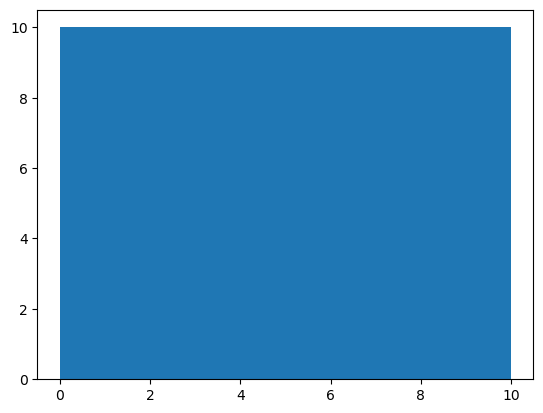

In [54]:
plt.hist(xs);

In [67]:
num_samples = 30

Finding kernel functions to estimate the data density can be difficult. Here, we use Gaussian kernels and set the standard deviation based on the number of samples and the dimensionality.

In [67]:
kernel_scale1d = 0.12 * kernel_scale_factor(dimensionality=1, num_points=100, num_samples=num_samples)
kernel_scale1d

0.4

In [68]:
density_estimator = KernelDensityEstimator(points, GaussianKernel(sigma=kernel_scale1d))
vc = VoidAndCluster(density_estimator, points.shape[0], num_initial_samples=10)

sample_indices = vc.sample(size=num_samples)
samples = points[sample_indices]

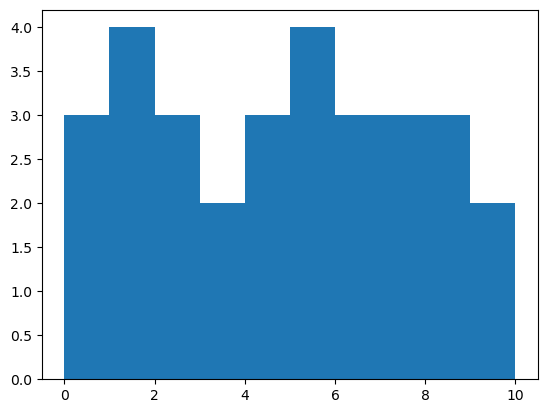

In [69]:
plt.hist(samples, bins=10);

In contrast, random sampling gives very different results

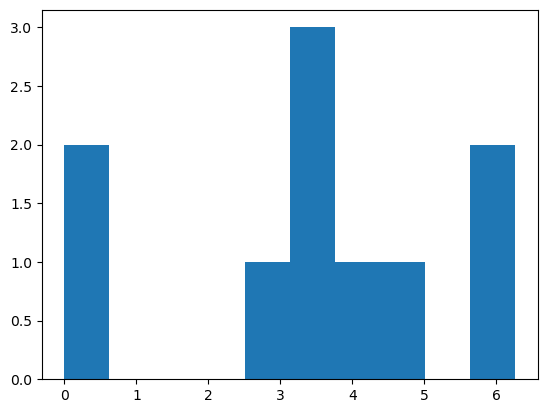

In [70]:
random_samples = np.random.choice(xs, replace=False, size=10)
plt.hist(random_samples);

## Sampling in 2D

In [71]:
num_points = 1000
xs = np.random.uniform(-1.0, 1.0, num_points)
ys = np.random.uniform(-1.0, 1.0, num_points)
points = np.stack([xs, ys]).T

In [72]:
kernel_bandwidth = 0.025 * kernel_scale_factor(dimensionality=2, num_points=num_points, num_samples=100)
kernel_bandwidth

0.0790569415042095

In [73]:
density_estimator = KernelDensityEstimator(points, GaussianKernel(sigma=kernel_bandwidth))
vc = VoidAndCluster(density_estimator, num_points, num_initial_samples=50)

sample_indices = vc.sample(size=100)
samples = points[sample_indices]

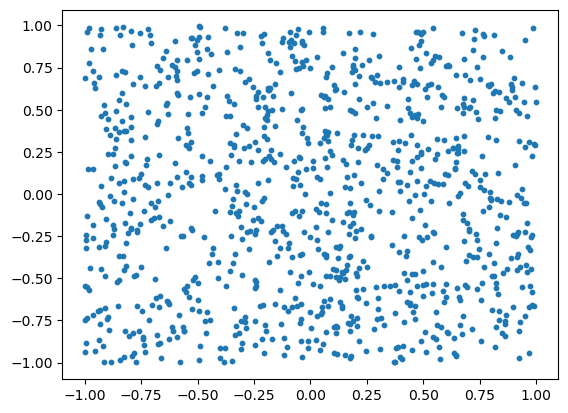

In [74]:
plt.scatter(x=points[:,0], y=points[:,1], s=10);

Not surprisingly, a spectral analysis using the Fourier transform does not show any structure in the full data set.

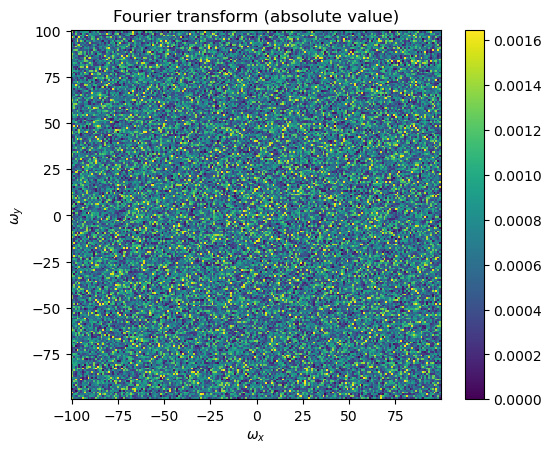

In [75]:
img_full = spectral_analysis.discretize_as_image(xs=points[:,0], ys=points[:,1], resolution=(200, 200))
spectral_analysis.plot_fourier_transform(img_full);

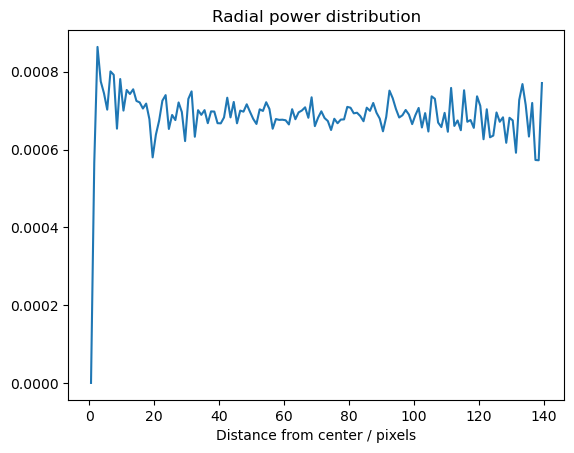

In [76]:
spectral_analysis.plot_power_distribution(img_full);

### Sampled Points

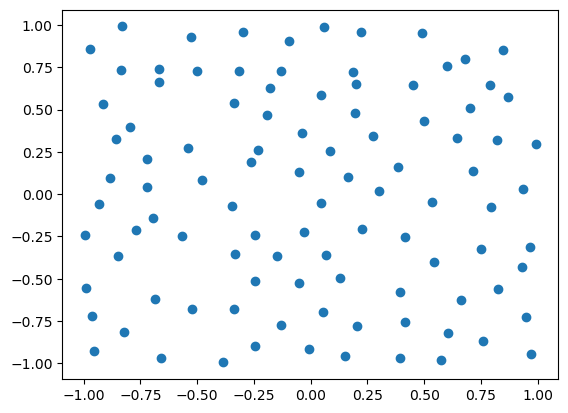

In [77]:
plt.scatter(x=samples[:,0], y=samples[:,1]);

Spectral analysis reveals _blue noise_, i.e. low frequencies have low energy (blue region in the Fourier transform plot)

In [17]:
img_sampled = spectral_analysis.discretize_as_image(xs=samples[:,0], ys=samples[:,1], resolution=(200, 200))

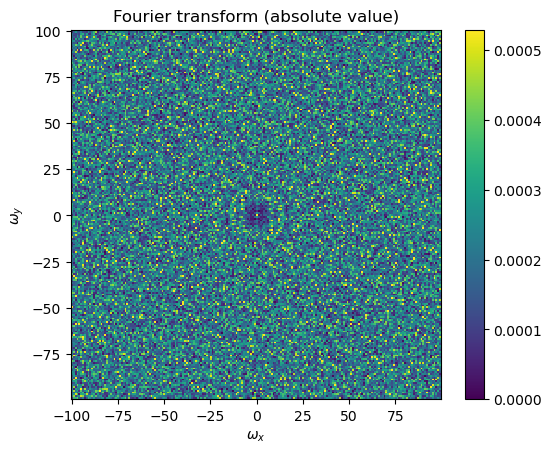

In [18]:
spectral_analysis.plot_fourier_transform(img_sampled);

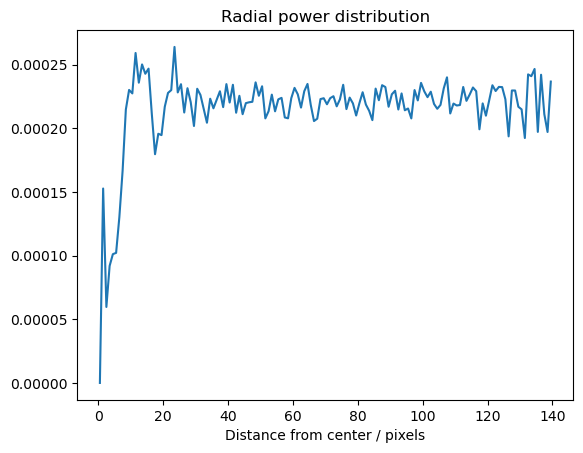

In [19]:
spectral_analysis.plot_power_distribution(img_sampled);

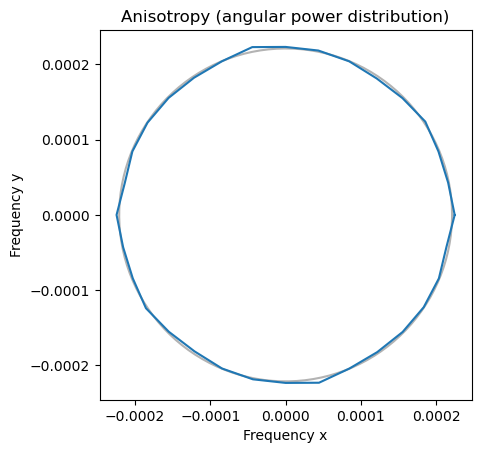

In [20]:
spectral_analysis.plot_anisotropy(img_sampled);

## Sampling a noisy sinus in 2D

In [21]:
num = 2000
num_samples = 200

ys = np.sin(np.linspace(-3.0, 3.0, num)) + np.random.normal(loc=0, scale=0.4, size=num)
xs = np.linspace(-3.0, 3.0, num)
points = np.stack([xs, ys]).T

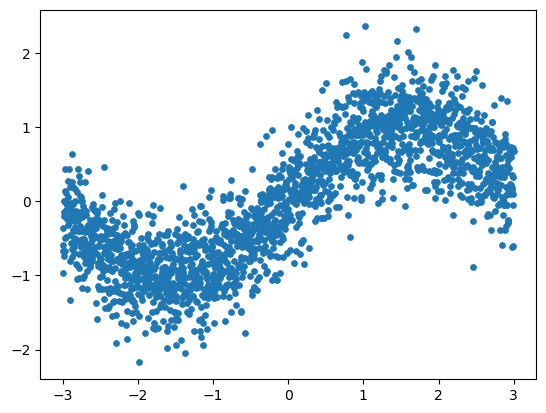

In [22]:
plt.scatter(xs, ys, s=15);

In [23]:
kernel_bandwidth = 0.055 * kernel_scale_factor(dimensionality=2, num_points=num_points, num_samples=num_samples)
kernel_bandwidth

0.12298373876248844

In [24]:
density_estimator = KernelDensityEstimator(points, GaussianKernel(sigma=kernel_bandwidth),
                                           divide_data_density=True)

The density estimation divides out the original density of the data so that samples are distributed just like the original data.

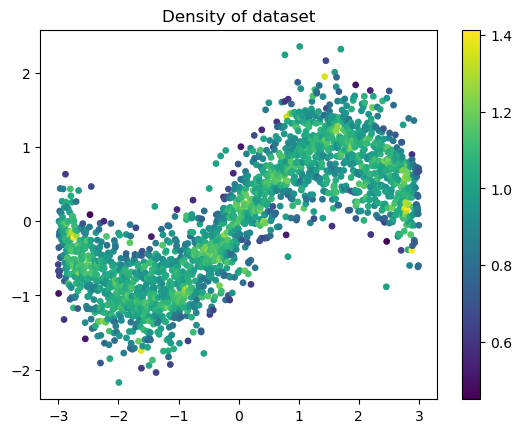

In [25]:
density = density_estimator.estimate()
plt.title('Density of dataset')
plt.scatter(xs, ys, c=density, s=15);
plt.colorbar();

In [26]:
vc = VoidAndCluster(density_estimator, points.shape[0], num_initial_samples=50)
sample_indices = vc.sample(size=num_samples)
samples = points[sample_indices]

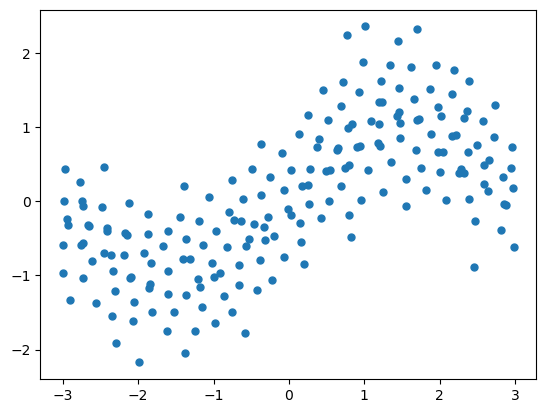

In [27]:
plt.scatter(x=samples[:,0], y=samples[:,1], s=25);

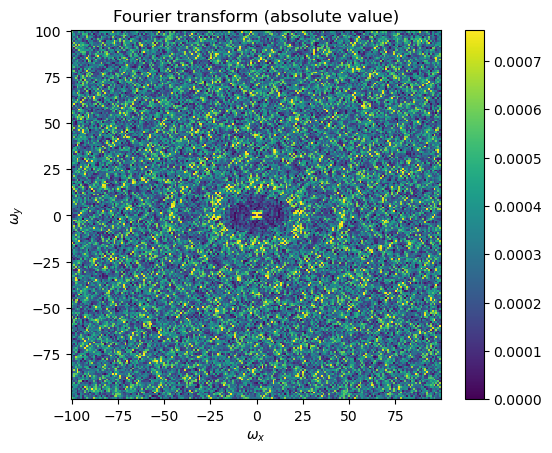

In [28]:
img_sampled = spectral_analysis.discretize_as_image(xs=samples[:,0], ys=samples[:,1], resolution=(200, 200))
spectral_analysis.plot_fourier_transform(img_sampled);

### Sampling with non-uniform probabilities in 2D

In [29]:
x = np.linspace(-1.0, 1.0, 60)
xy = np.outer(x, x)
xs = np.tile(x, x.shape)
ys = np.repeat(x, x.shape)
points = np.stack([xs, ys]).T

ps = np.clip(1 - np.abs(np.sin(xs*0.5)*2) + 0.1, 0.0, 1.0)

num_samples = 500
num_points = xs.shape[0]
num_points

3600

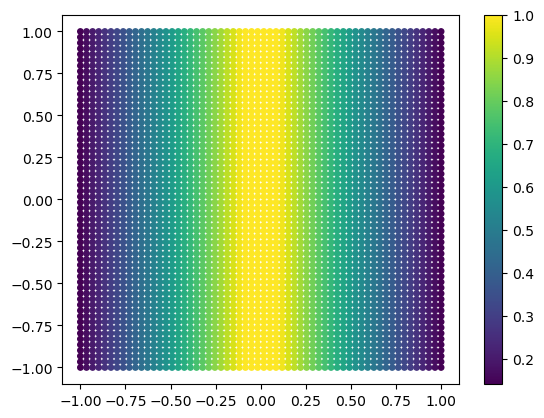

In [30]:
plt.scatter(xs, ys, c=ps, s=15);
plt.colorbar();

In [31]:
kernel_bandwidth = 0.015 * kernel_scale_factor(dimensionality=2, num_points=num_points, num_samples=num_samples)
kernel_bandwidth

0.04024922359499621

Non-uniform sampling is achieved by factoring it in (or rather its inverse) in the density estimation. 

In [32]:
density_estimator = KernelDensityEstimator(points, GaussianKernel(sigma=kernel_bandwidth),
                                           divide_data_density=True, importance=ps)
vc = VoidAndCluster(density_estimator, num_points, num_initial_samples=100)

sample_indices = vc.sample(size=num_samples)
samples = points[sample_indices]

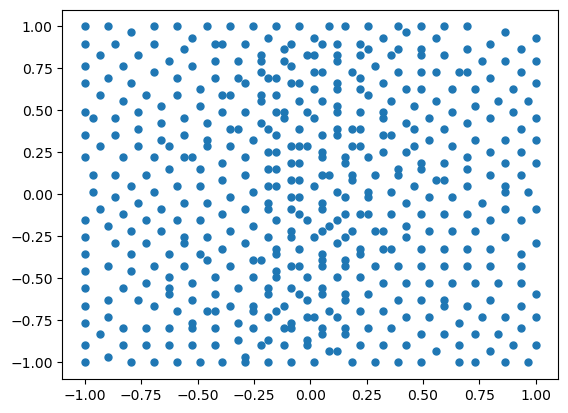

In [33]:
plt.scatter(samples[:,0], samples[:,1], s=25);

### Sampling a Gaussian in 3D

In [34]:
num = 1000
num_samples = 100

xs = np.random.normal(loc=0, scale=1.0, size=num)
ys = np.random.normal(loc=0, scale=1.0, size=num)
zs = np.random.normal(loc=0, scale=1.0, size=num)
points = np.stack([xs, ys, zs]).T

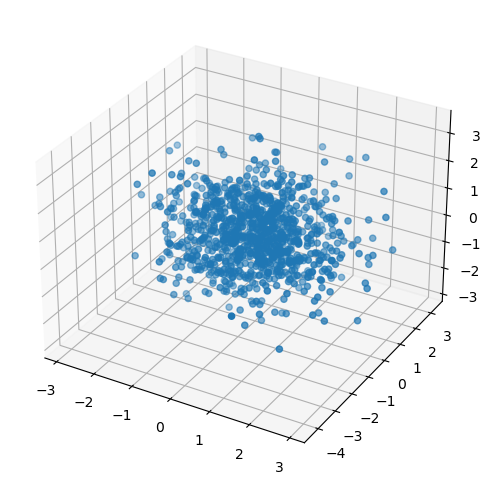

In [35]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs, ys, zs);

In [36]:
kernel_bandwidth = 0.25 * kernel_scale_factor(dimensionality=3, num_points=num_points, num_samples=num_samples)
kernel_bandwidth

0.8254818122236566

In [37]:
density_estimator = KernelDensityEstimator(points, GaussianKernel(sigma=kernel_bandwidth))

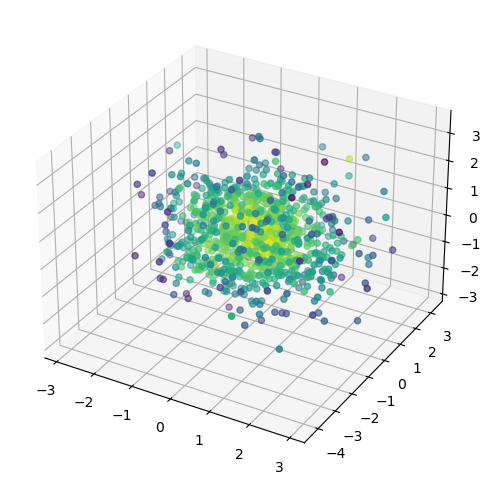

In [38]:
density = density_estimator.estimate()

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs, ys, zs, c=density);

In [39]:
vc = VoidAndCluster(density_estimator, points.shape[0], num_initial_samples=50)
sample_indices = vc.sample(size=num_samples)
samples = points[sample_indices]

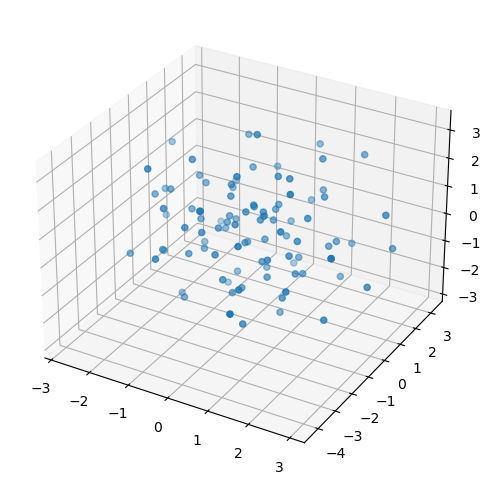

In [40]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(samples[:,0], samples[:,1], samples[:,2]);